In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load image data
image_data = np.load('data/image_data.npy', allow_pickle=True)
image_labels = pd.read_csv('data/labels.csv')

In [3]:
# Convert image_data to a DataFrame
image_data_df = pd.DataFrame(image_data, columns=['data'])

# Concatenate image_labels and image_data_df
df = pd.concat([image_labels, image_data_df], axis=1)

In [4]:
df.head()

category                                               data
0     Rice  [1934, 1982, 1908, 1892, 1960, 2002, 1952, 196...
1     Rice  [1678, 1644, 1662, 1658, 1650, 1608, 1698, 176...
2     Rice  [1954, 2256, 2290, 2386, 2396, 2582, 2674, 260...
3     Rice  [1871, 1802, 1750, 1687, 1759, 1728, 1927, 200...
4     Rice  [2254, 1948, 1870, 1802, 1662, 1584, 1590, 158...

In [5]:
df.tail()

category                                               data
595  Non Rice  [5928, 5900, 5900, 5840, 5752, 5696, 5696, 563...
596  Non Rice  [5928, 5980, 6008, 5984, 5912, 5752, 5696, 580...
597  Non Rice  [6020, 6052, 6096, 6068, 6024, 5840, 5752, 576...
598  Non Rice  [5988, 6052, 6112, 6172, 6052, 6004, 5976, 584...
599  Non Rice  [6184, 6180, 6180, 6184, 6148, 6060, 5928, 583...

In [6]:
def preprocess_images(df):
    # Resize images to target size (224, 224) and stack them into a single NumPy array
    resized_images = np.stack([cv2.resize(img, (224, 224)) for img in df['data'].values])
    
    # Ensure the channel dimension is included
    resized_images = np.expand_dims(resized_images, axis=-1)
    resized_images = np.repeat(resized_images, 3, axis=-1)

    # Convert categories to binary labels (assuming two categories: 'Category1' and 'Category2')
    binary_labels = df['category'].map({'Non Rice': 0, 'Rice': 1}).values

    return resized_images, binary_labels


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(sss.split(df, df['category']))
train_df = df.iloc[train_idx]
temp_df = df.iloc[temp_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss.split(temp_df, temp_df['category']))
val_df = temp_df.iloc[val_idx]
test_df = temp_df.iloc[test_idx]

train_images, train_labels = preprocess_images(train_df)
val_images, val_labels = preprocess_images(val_df)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

In [8]:
train_df.head()

category                                               data
508  Non Rice  [2086, 1732, 1893, 2750, 3422, 2698, 2178, 179...
411  Non Rice  [4908, 5400, 6092, 6248, 6392, 6376, 6296, 609...
437  Non Rice  [6096, 6200, 6372, 6340, 6216, 6044, 5776, 562...
521  Non Rice  [2698, 2178, 1794, 1553, 1496, 1950, 1709, 195...
15       Rice  [2412, 2500, 2562, 2664, 2706, 2780, 2776, 274...

### ResNet50

In [9]:
def resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the layers of the base model (ResNet50)
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [11]:
model = resnet50_model()

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator, 
          validation_data=val_generator, 
          epochs=20)

Epoch 1/20
12/12 [==============================] - 40s 3s/step - loss: 0.2520 - accuracy: 0.8722 - val_loss: 0.4327 - val_accuracy: 0.7333
Epoch 2/20
12/12 [==============================] - 36s 3s/step - loss: 0.0882 - accuracy: 0.9722 - val_loss: 0.3050 - val_accuracy: 0.7750
Epoch 3/20
12/12 [==============================] - 36s 3s/step - loss: 0.0479 - accuracy: 0.9889 - val_loss: 0.2501 - val_accuracy: 0.9250
Epoch 4/20
12/12 [==============================] - 37s 3s/step - loss: 0.0294 - accuracy: 0.9889 - val_loss: 0.2293 - val_accuracy: 0.9333
Epoch 5/20
12/12 [==============================] - 37s 3s/step - loss: 0.0197 - accuracy: 0.9972 - val_loss: 0.2088 - val_accuracy: 0.9417
Epoch 6/20
12/12 [==============================] - 37s 3s/step - loss: 0.0194 - accuracy: 0.9972 - val_loss: 0.1798 - val_accuracy: 0.9667
Epoch 7/20
12/12 [==============================] - 33s 3s/step - loss: 0.0230 - accuracy: 0.9917 - val_loss: 0.1575 - val_accuracy: 0.9750
Epoch 8/20
12/12 [==

In [12]:
test_images, test_labels = preprocess_images(test_df)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

In [13]:
y_pred = model.predict(test_generator)
y_pred_classes = np.where(y_pred > 0.5, 'Rice', 'Non Rice')
y_true = test_df['category'].values

print(classification_report(y_pred_classes, y_true))

4/4 [==============================] - 7s 1s/step
              precision    recall  f1-score   support

    Non Rice       0.53      0.52      0.52        62
        Rice       0.50      0.52      0.51        58

    accuracy                           0.52       120
   macro avg       0.52      0.52      0.52       120
weighted avg       0.52      0.52      0.52       120



In [14]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):

    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

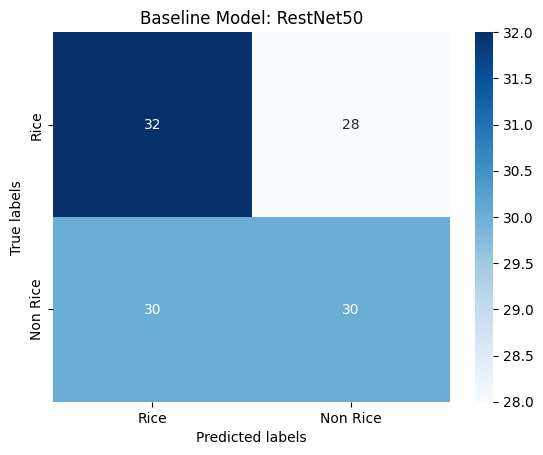

In [15]:
plot_confusion_matrix(y_true, y_pred_classes,"Baseline Model: RestNet50",['Rice', 'Non Rice'])

### EfficientNet

In [16]:
from tensorflow.keras.applications import EfficientNetB0
efficient = EfficientNetB0(weights='imagenet')

In [17]:
def efficient_model():

    model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = Model(model.input, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

efficient_model = efficient_model()
epochs = 20
history = efficient_model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/20
12/12 [==============================] - 89s 6s/step - loss: 0.3268 - accuracy: 0.8361 - val_loss: 0.6300 - val_accuracy: 0.6667
Epoch 2/20
12/12 [==============================] - 56s 5s/step - loss: 0.1338 - accuracy: 0.9528 - val_loss: 1.1111 - val_accuracy: 0.7250
Epoch 3/20
12/12 [==============================] - 50s 4s/step - loss: 0.0384 - accuracy: 0.9806 - val_loss: 3.9467 - val_accuracy: 0.5583
Epoch 4/20
12/12 [==============================] - 46s 4s/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 3.8432 - val_accuracy: 0.5000
Epoch 5/20
12/12 [==============================] - 48s 4s/step - loss: 0.0391 - accuracy: 0.9833 - val_loss: 29.1987 - val_accuracy: 0.5000
Epoch 6/20
12/12 [==============================] - 60s 5s/step - loss: 0.1003 - accuracy: 0.9778 - val_loss: 102.4896 - val_accuracy: 0.5000
Epoch 7/20
12/12 [==============================] - 47s 4s/step - loss: 0.0723 - accuracy: 0.9778 - val_loss: 59.0763 - val_accuracy: 0.5000
Epoch 8/20
12/12

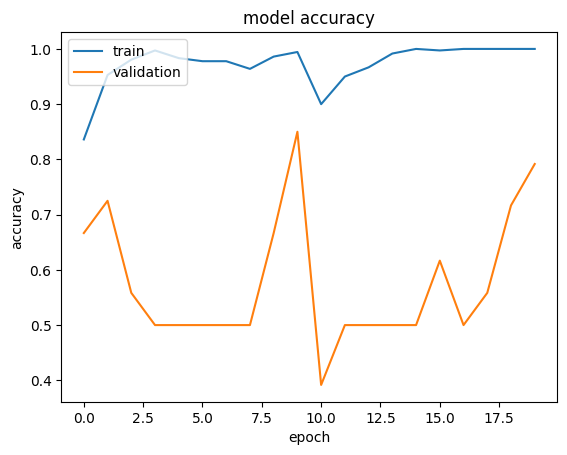

In [18]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

4/4 [==============================] - 5s 806ms/step
              precision    recall  f1-score   support

    Non Rice       0.27      0.52      0.35        31
        Rice       0.75      0.51      0.60        89

    accuracy                           0.51       120
   macro avg       0.51      0.51      0.48       120
weighted avg       0.63      0.51      0.54       120



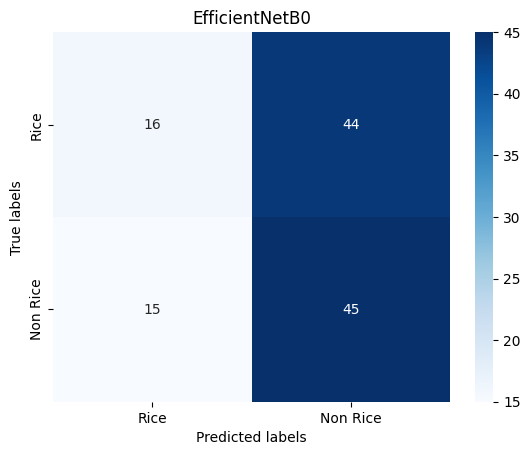

In [19]:
y_pred = efficient_model.predict(test_generator)
y_pred_classes = np.where(y_pred > 0.5, 'Rice', 'Non Rice')
y_true = test_df['category'].values

print(classification_report(y_pred_classes, y_true))
plot_confusion_matrix(y_true, y_pred_classes,"EfficientNetB0",['Rice', 'Non Rice'])